In this project you will practice optimizing various aspects of a machine learning model for predicting stock price movements. This will provide you with an opportunity to integrate the concepts covered in the course, such as data preprocessing and cleaning, hyperparameter tuning, detecting and addressing over-/under-fitting, model evaluation, and feature selection techniques. While you will use real-world data in this project, the goal is not necessarily to build a "winning" trading _strategy_. The goal of this course has been to equip you with the tools, techniques, concepts and insights you need to evaluate, optimize and monitor *your own* trading strategies.


**NOTE:** **The references of this project included the course materials, the documents of Numpy, Pandas, matplotlib, Skit-Learn, Google search, and ChatGPT, etc..**

# Optimizing AI Trading Algorithms - Course Project


## The Scenario

You are an analyst at a boutique investment firm tasked with coming up with a novel idea for investing in specific sectors of the industry. You've heard that the Utilities, Consumer Staples and Healthcare sectors are relatively resilient to economic shocks and recessions, and that stock market investors tend to flock to these sectors in times of uncertainty. You decide to take the [SPDR Healthcase Sector ETF (NYSEARCA: XLV)](https://www.sectorspdrs.com/mainfund/XLV) and try to model its returns' dynamics using a machine learning AI strategy. Your novel idea is to get data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) as a proxy for uncertainty in the market. You also decide to take a look at [Google Trends data](https://trends.google.com/trends/explore?date=all&geo=US&q=recession) for the search term "recession" in the United States, in order to try and see if there is any meaningful relationship between the general public's level of concern about a recession happening and the price movements of the Health Care Select Sector SPDR Fund.


You decide to train a binary **classification** model that merely attempts to predict the **direction** of XLV's 5-day price movements. In other words, you want to see if on any given day, with the above data in hand, you could reliably predict whether the price of XLV will increase or decrease over the next 5 trading days.

Run the cell below to `import` all the Python packages and modules you will be using throughout the project.

In [1]:
!pip install --upgrade pip yfinance ta --quiet

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

RANDOM_SEED = 42

## 1. Data Acquisition, Exploration, Cleaning and Preprocessing


In this section, you will download and inspect:

- daily data for the SPDR Healthcase Sector ETF (NYSEARCA: XLV)
- daily data for the volatility index (INDEXCBOE: VIX)
- monthly data from Google Trends for the search interest in the term "recession" in the United States

The goal is to make sure the data is clean, meaningful, and usable for selecting and engineering features.


### 1.1. Price and Volume Data for "XLV"


We have downloded daily data from **January 1st, 2004** to **March 31st, 2024** for the ticker **XLV** using the `yfinance` library and stored it in a CSV file named `xlv_data.csv`. Load this data into a Pandas DataFrame named `xlv_data`, making sure to set the index column to the first column of the CSV file (`Date`) and set `parse_dates=True`.


In [3]:
xlv_data = pd.read_csv('xlv_data.csv', index_col=0, parse_dates=True)

print(xlv_data)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-01-02   30.200001   30.440001   30.120001   30.219999   21.567184   
2004-01-05   30.400000   30.500000   30.139999   30.360001   21.667091   
2004-01-06   30.469999   30.480000   30.309999   30.450001   21.731337   
2004-01-07   30.450001   30.639999   30.309999   30.639999   21.866926   
2004-01-08   30.700001   30.700001   30.320000   30.510000   21.774158   
...                ...         ...         ...         ...         ...   
2024-03-22  145.850006  146.220001  145.259995  145.440002  145.440002   
2024-03-25  145.710007  145.860001  145.009995  145.240005  145.240005   
2024-03-26  145.529999  145.940002  145.139999  145.770004  145.770004   
2024-03-27  147.009995  147.710007  146.619995  147.710007  147.710007   
2024-03-28  147.919998  148.229996  147.679993  147.729996  147.729996   

             Volume  
Date           

Use the `info()` and `describe()` methods to get an overview of how many rows of data there are in `xlv_data`, what columns are present and what their data types are, and what some basic statistics (mean, std, quartiles, min/max values) of the columns look like.


In [4]:
# Get a summary of the DataFrame
xlv_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2004-01-02 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5094 non-null   float64
 1   High       5094 non-null   float64
 2   Low        5094 non-null   float64
 3   Close      5094 non-null   float64
 4   Adj Close  5094 non-null   float64
 5   Volume     5094 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 278.6 KB


In [5]:
# Get basic statistics for the numerical columns
xlv_data.describe()

Open         High          Low        Close    Adj Close  \
count  5094.000000  5094.000000  5094.000000  5094.000000  5094.000000   
mean     65.342311    65.730397    64.924197    65.349097    58.242299   
std      36.695351    36.915853    36.477869    36.712468    37.932219   
min      22.010000    22.290001    21.629999    21.879999    16.812475   
25%      31.990000    32.132501    31.812500    31.990000    24.508568   
50%      57.100000    57.400000    56.680000    57.010000    48.387001   
75%      90.657503    91.077497    89.927500    90.557499    82.941315   
max     147.919998   148.270004   147.679993   147.860001   147.729996   

             Volume  
count  5.094000e+03  
mean   7.228951e+06  
std    5.445803e+06  
min    5.870000e+04  
25%    3.790550e+06  
50%    6.582850e+06  
75%    9.559550e+06  
max    6.647020e+07

How many `NaN` rows are there in `xlv_data`?


In [6]:
# Count rows with NaN values
num_nan_rows = xlv_data.isnull().sum().sum()
print(f"Number of NaN rows: {num_nan_rows}")

Number of NaN rows: 0


Take a look at the final five rows of `xlv_data`.


In [7]:
xlv_data.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-03-22  145.850006  146.220001  145.259995  145.440002  145.440002   
2024-03-25  145.710007  145.860001  145.009995  145.240005  145.240005   
2024-03-26  145.529999  145.940002  145.139999  145.770004  145.770004   
2024-03-27  147.009995  147.710007  146.619995  147.710007  147.710007   
2024-03-28  147.919998  148.229996  147.679993  147.729996  147.729996   

             Volume  
Date                 
2024-03-22  5537200  
2024-03-25  5253000  
2024-03-26  6942400  
2024-03-27  8797400  
2024-03-28  8090200

Raw OHLC data is not suitable for training models. The absolute price level of a security is boundless in theory and not particularly menaningful. In the next section, you are going to engineer useful features from all of these columns. For now, as a visual sanity check, plot `Adj Close` as a line plot.


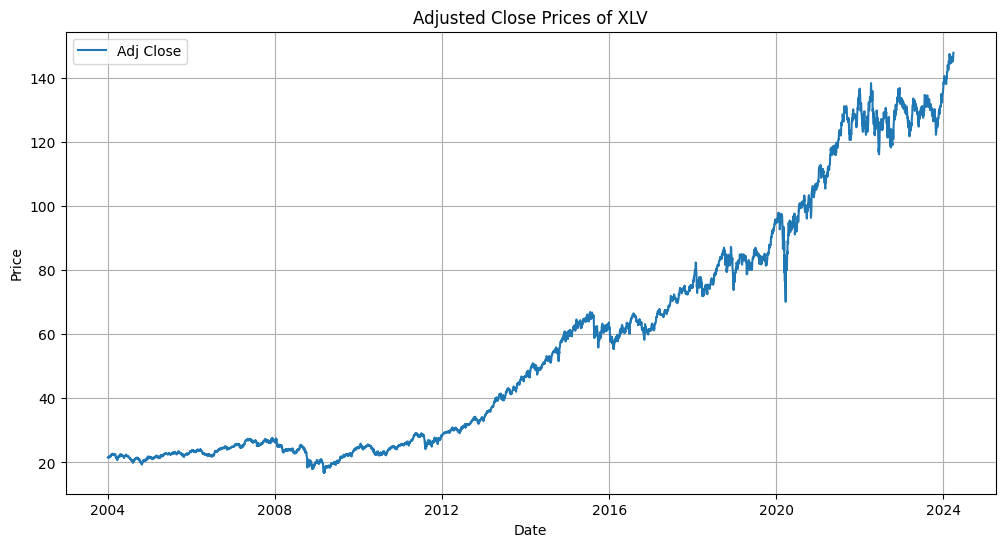

In [8]:
# Plot the 'Adj Close' column
plt.figure(figsize=(12, 6))
plt.plot(xlv_data['Adj Close'], label='Adj Close')
plt.title('Adjusted Close Prices of XLV')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


**Bonus**: The cell below plots the combined candlestick + volume chart for the last 15 months of data using Plotly.


In [9]:
data_since_2023 = xlv_data["2023-01-01":]

figure = make_subplots(specs=[[{"secondary_y": True}]])
figure.add_traces(
    go.Candlestick(
        x=data_since_2023.index,
        open=data_since_2023.Open,
        high=data_since_2023.High,
        low=data_since_2023.Low,
        close=data_since_2023.Close,
    ),
    secondary_ys=[True],
)
figure.add_traces(
    go.Bar(x=data_since_2023.index, y=data_since_2023.Volume, opacity=0.5),
    secondary_ys=[False],
)

figure.update_layout(
    title="XLV Candlestick Chart Since 2023",
    xaxis_title="Date",
    yaxis_title="Volume",
    yaxis2_title="Price",
    showlegend=False,
)
figure.update_yaxes(fixedrange=False)
figure.layout.yaxis2.showgrid = False
figure.show()

### 1.2. Data for The Volatility Index `VIX`


As before, we have downloaded daily data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) over the same time period using `yfinance` and provided it to you in a CSV file named `vix_data.csv`. Load the data into a variable named `vix_data`. Make sure to set the index and parse the dates correctly.


In [10]:
# Load the VIX data
vix_data = pd.read_csv('vix_data.csv', index_col=0, parse_dates=True)
print(vix_data)

                 Open   High        Low      Close  Adj Close  Volume
Date                                                                 
2004-01-02  17.959999  18.68  17.540001  18.219999  18.219999       0
2004-01-05  18.450001  18.49  17.440001  17.490000  17.490000       0
2004-01-06  17.660000  17.67  16.190001  16.730000  16.730000       0
2004-01-07  16.719999  16.75  15.500000  15.500000  15.500000       0
2004-01-08  15.420000  15.68  15.320000  15.610000  15.610000       0
...               ...    ...        ...        ...        ...     ...
2024-03-22  12.920000  13.15  12.580000  13.060000  13.060000       0
2024-03-25  13.670000  13.67  13.110000  13.190000  13.190000       0
2024-03-26  13.120000  13.43  12.840000  13.240000  13.240000       0
2024-03-27  13.130000  13.34  12.660000  12.780000  12.780000       0
2024-03-28  12.930000  13.10  12.840000  13.010000  13.010000       0

[5094 rows x 6 columns]


Plot a line chart of the `Adj Close` value of the VIX using your method of choice (e.g. `plotly` or `matplotlib`).


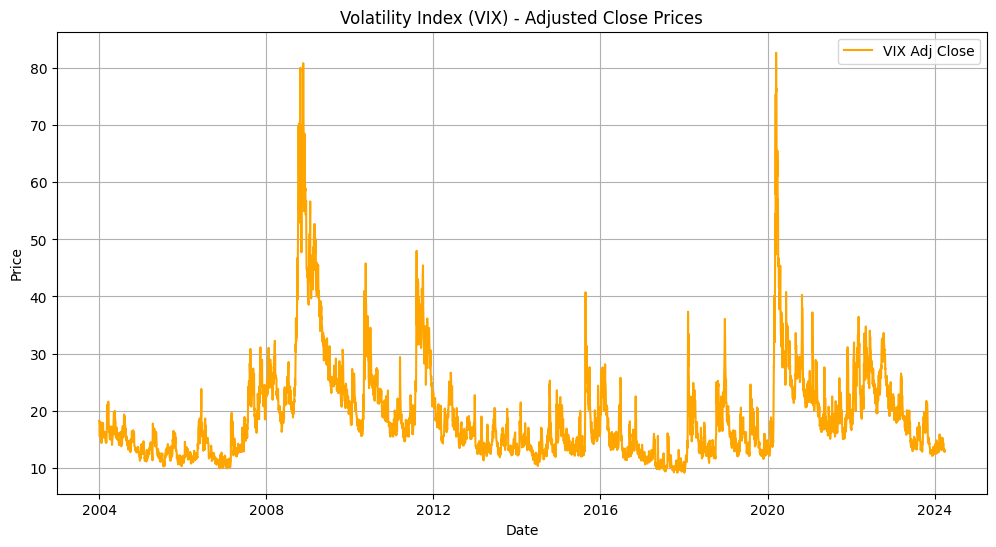

In [11]:
# Plot Adj Close as a line chart
plt.figure(figsize=(12, 6))
plt.plot(vix_data['Adj Close'], label='VIX Adj Close', color='orange')
plt.title('Volatility Index (VIX) - Adjusted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


### 1.3. Google Trends Data


The **monthly** evolution of search interest in the term "recession" in the U.S. over the period of interest (Jan. 2003 - Mar. 2024) from the Google Trends website has been provided to you as a CSV file. We will load this data using Pandas into a DataFrame named `google_trends_data`, set the index column of the DataFrame to the "`Month`" column from the CSV and have Pandas try and parse these dates automatically.

> Note: The "Month" column in the CSV is in "YYYY-MM" format.


In [12]:
google_trends_data = pd.read_csv('GoogleTrendsData.csv', index_col='Month', parse_dates=True)

# Display the DataFrame
print(google_trends_data)

            recession_search_trend
Month                             
2004-01-01                       4
2004-02-01                       4
2004-03-01                       5
2004-04-01                       6
2004-05-01                       4
...                            ...
2023-11-01                      16
2023-12-01                      13
2024-01-01                      12
2024-02-01                      16
2024-03-01                      13

[243 rows x 1 columns]


As noted above, the CSV lists **monthly** search trends data and the `Month` column is in YYYY-MM format. How has Pandas interpreted and parsed these into specific dates? Take a look at `google_trends_data`'s index.


In [13]:
# Display the Index
print(google_trends_data.index)

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01',
               '2024-02-01', '2024-03-01'],
              dtype='datetime64[ns]', name='Month', length=243, freq=None)


We would have liked to assign the data points to the last day of the respective months, as this data would have been available at the _end_ of each period. Shift the index column of `google_trends_data` to do this.

> Hint: You can use `pd.offsets.MonthEnd()` from Pandas.


In [14]:
google_trends_data.index = google_trends_data.index + pd.offsets.MonthEnd(0)

print(google_trends_data)
print(google_trends_data.index)

            recession_search_trend
Month                             
2004-01-31                       4
2004-02-29                       4
2004-03-31                       5
2004-04-30                       6
2004-05-31                       4
...                            ...
2023-11-30                      16
2023-12-31                      13
2024-01-31                      12
2024-02-29                      16
2024-03-31                      13

[243 rows x 1 columns]
DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31',
               ...
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31'],
              dtype='datetime64[ns]', name='Month', length=243, freq=None)


Run the cell below to visualize this data as a line plot.

> **Note from Google:** "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."


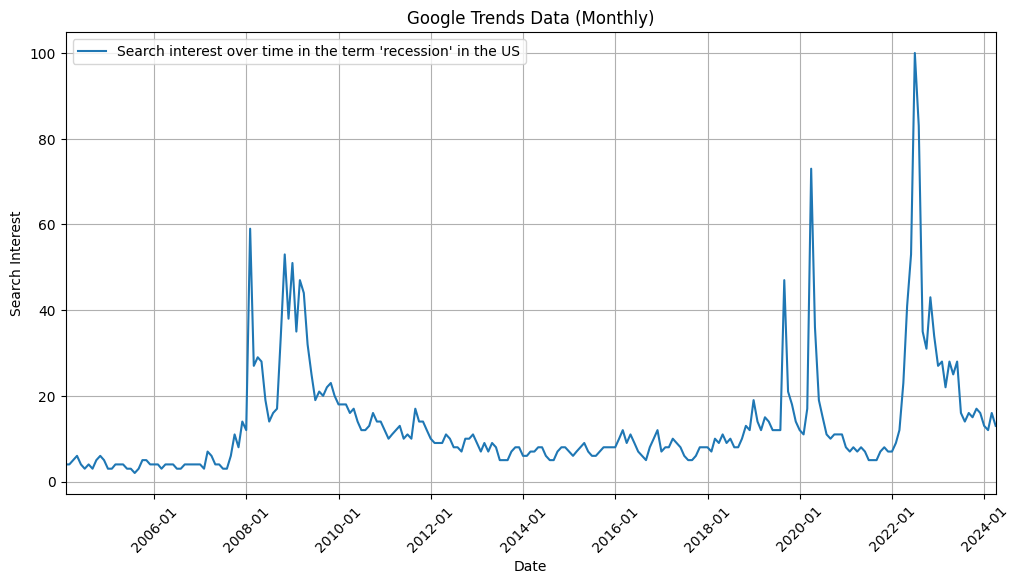

In [15]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(google_trends_data)
date_fmt = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_fmt)
plt.xlim(google_trends_data.index[0], google_trends_data.index[-1])
plt.xticks(rotation=45)
plt.title("Google Trends Data (Monthly)")
plt.xlabel("Date")
plt.ylabel("Search Interest")
plt.legend(["Search interest over time in the term 'recession' in the US"])
plt.grid()
plt.show()

But not every month-end is a trading day. Also, what value should the model train on for all the days in between month-ends? Below, we have provided you with code to convert the monthly data to daily and interpolate the end-of-month values to get all the in-between values. You will be using this new `google_trends_daily` data going forward.


In [16]:
# Convert to daily frequency and interpolate
google_trends_daily = google_trends_data.resample('D').asfreq().interpolate(method='linear')

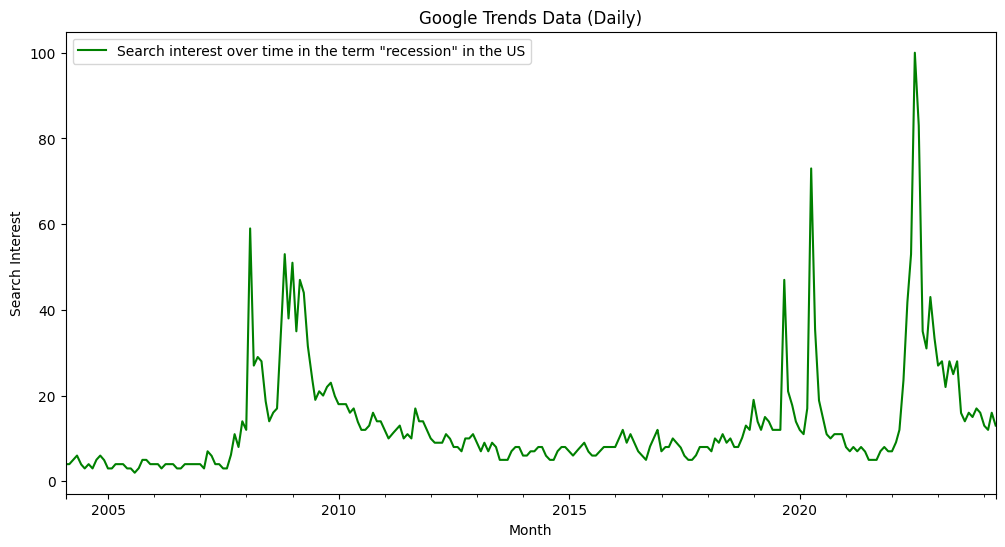

In [17]:
# # The shape of the chart should not have changed
# Plot the interpolated data
google_trends_daily.plot.line(
    title="Google Trends Data (Daily)", 
    figsize=(12, 6), 
    legend=True, 
    color='green',
    xlabel="Month",
    ylabel="Search Interest",
).legend(
    labels=['Search interest over time in the term "recession" in the US']
)
plt.show()


## 2. Feature Engineering and Analysis


In this section, you will create a new DataFrame called `data` which will house all of the features as well as the prediction target. Then you will analyze the features and look for potentially problematic features.

Start by running the cell below to create `data` as an empty DataFrame with just an index that matches `XLV`'s.


In [18]:
# Create an empty DataFrame with the same index as xlv_data
data = pd.DataFrame(index=xlv_data.index)

# Display the empty DataFrame
print(data)

Empty DataFrame
Columns: []
Index: [2004-01-02 00:00:00, 2004-01-05 00:00:00, 2004-01-06 00:00:00, 2004-01-07 00:00:00, 2004-01-08 00:00:00, 2004-01-09 00:00:00, 2004-01-12 00:00:00, 2004-01-13 00:00:00, 2004-01-14 00:00:00, 2004-01-15 00:00:00, 2004-01-16 00:00:00, 2004-01-20 00:00:00, 2004-01-21 00:00:00, 2004-01-22 00:00:00, 2004-01-23 00:00:00, 2004-01-26 00:00:00, 2004-01-27 00:00:00, 2004-01-28 00:00:00, 2004-01-29 00:00:00, 2004-01-30 00:00:00, 2004-02-02 00:00:00, 2004-02-03 00:00:00, 2004-02-04 00:00:00, 2004-02-05 00:00:00, 2004-02-06 00:00:00, 2004-02-09 00:00:00, 2004-02-10 00:00:00, 2004-02-11 00:00:00, 2004-02-12 00:00:00, 2004-02-13 00:00:00, 2004-02-17 00:00:00, 2004-02-18 00:00:00, 2004-02-19 00:00:00, 2004-02-20 00:00:00, 2004-02-23 00:00:00, 2004-02-24 00:00:00, 2004-02-25 00:00:00, 2004-02-26 00:00:00, 2004-02-27 00:00:00, 2004-03-01 00:00:00, 2004-03-02 00:00:00, 2004-03-03 00:00:00, 2004-03-04 00:00:00, 2004-03-05 00:00:00, 2004-03-08 00:00:00, 2004-03-09 00:00:00

### 2.1. Feature Engineering


#### 2.1.1. Month and Weekday


Add the `month` and `weekday` columns to `data` as categorical features (integer labels) from its index.


In [19]:
# Add the month column
data['month'] = data.index.month

# Add the weekday column (Monday=0, Sunday=6)
data['weekday'] = data.index.weekday

# Display the updated DataFrame
print(data.head())

            month  weekday
Date                      
2004-01-02      1        4
2004-01-05      1        0
2004-01-06      1        1
2004-01-07      1        2
2004-01-08      1        3


You do not want to train a model using these columns as they are, because the numbers themselves and the inherent "order" of months and weekdays do not really have any significance, but the model may interpret them as meaningful. You could either (a) use one-hot encoding to turn each category to a separate binary feature, or (b) treat them as cyclical features. The choice is somewhat arbitrary and depends on how important a "feature" you believe the cyclicality to be.

Below, you will:

- Treat `month` as a cyclical feature, creating two features (`month_sin` and `month_cos`). (👉 See: [Trigonometric features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#trigonometric-features))
- One-hot-encode `weekday` and create five additional features of type `int32` (one for each business day) with the `weekday` prefix. (👉 See: [`pandas.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html))
- Make sure the original `month` and `weekday` columns are no longer present in `data`. (`drop()` them if necessary.)


In [20]:
# Treat `month` as a "cyclical" feature with a period of 12 months.
data["month_sin"] = np.sin(2 * np.pi * data["month"] / 12)
data["month_cos"] = np.cos(2 * np.pi * data["month"] / 12)

# Drop the original `month` column
data.drop(columns=["month"], inplace=True)

# Treat `weekday` as a "categorical" feature and one-hot-encode it.
data = pd.get_dummies(data, columns=["weekday"], prefix="weekday", dtype=np.int32)

# Display the updated DataFrame
print(data.head())


            month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  
Date                   
2004-01-02          1  
2004-01-05          0  
2004-01-06          0  
2004-01-07          0  
2004-01-08          0  


#### 2.1.2. Historical Returns


Next, add features for historical returns of the XLV ETF from its `Adj Close` column. For each date, calculate rolling **simple** returns over the past 1, 5, 10 and 20 days. Create 4 columns in `data` named `ret_#d_hist` where `#` is the lookback period. The list `hist_ret_lookbacks` is provided if you wish to use it.


In [21]:
# Create features for 1-day, 5-day, 10-day and 20-day historical returns
hist_ret_lookbacks = [1, 5, 10, 20]

# Verify Adj Close column exists, if not, add it from xlv_data
if "Adj Close" not in data.columns:
    data["Adj Close"] = xlv_data["Adj Close"]

# Safely handle missing values without `inplace=True`
data["Adj Close"] = data["Adj Close"].ffill()  # Forward fill
data["Adj Close"] = data["Adj Close"].bfill()  # Backward fill

# Compute historical returns for each lookback period
for n_days in hist_ret_lookbacks:
    data[f"ret_{n_days}d_hist"] = data["Adj Close"].pct_change(periods=n_days)

# Display the first few rows to verify
print(data[[f"ret_{n_days}d_hist" for n_days in hist_ret_lookbacks]].head())

            ret_1d_hist  ret_5d_hist  ret_10d_hist  ret_20d_hist
Date                                                            
2004-01-02          NaN          NaN           NaN           NaN
2004-01-05     0.004632          NaN           NaN           NaN
2004-01-06     0.002965          NaN           NaN           NaN
2004-01-07     0.006239          NaN           NaN           NaN
2004-01-08    -0.004242          NaN           NaN           NaN


The cell below plots the histograms of the returns you just calculated. They should look normally distributed around zero.


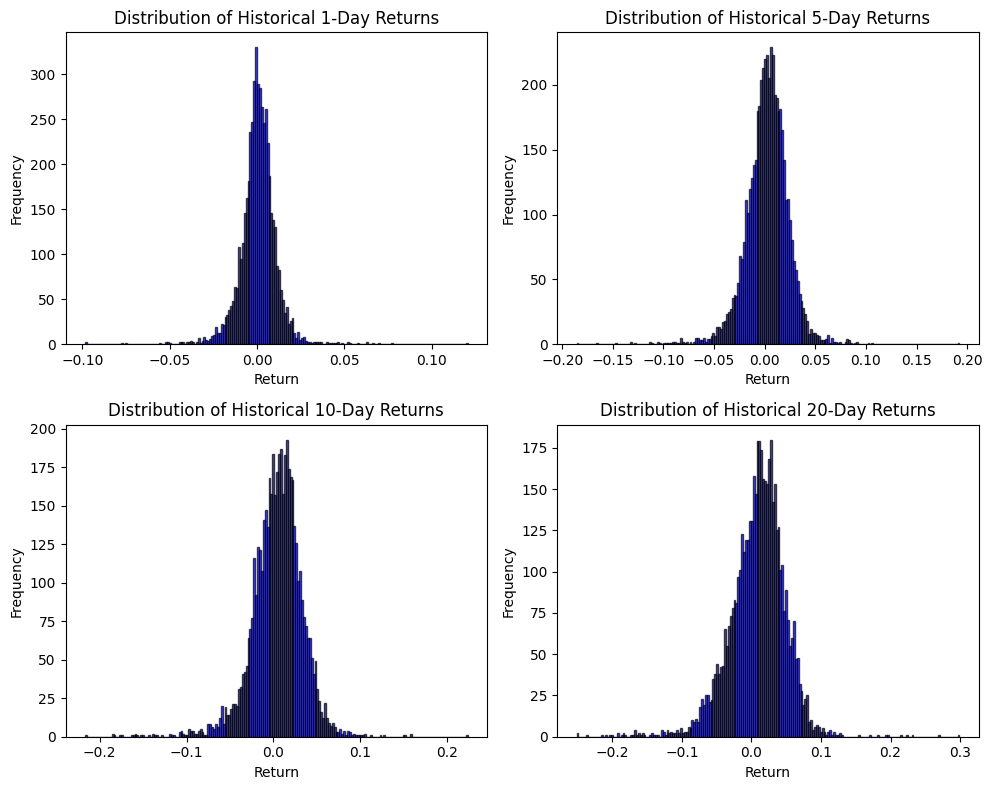

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

def plot_hist_returns(ax, data, col, title):
    """
    Function to plot histograms for historical returns
    """
    ax.hist(data[col], bins=200, color="blue", alpha=0.7, edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel("Return")
    ax.set_ylabel("Frequency")

# Loop through each lookback period and plot
for i, n_days in enumerate(hist_ret_lookbacks):
    column_name = f"ret_{n_days}d_hist"
    plot_hist_returns(
        axs[i // 2, i % 2],  # Select subplot axis
        data,  # DataFrame
        column_name,  # Column to plot
        f"Distribution of Historical {n_days}-Day Returns",  # Title
    )

plt.tight_layout()
plt.show()

#### 2.1.3. Trade Volumes

As trading volumes span several orders of magnitude, take the natural logarithm of `Volume` and use it as a feature instead. This helps emphasize variations in its lower range. Use `np.log()` and call this new feature `log_volume`.

**Note:** For tree-based models such as Decision Trees and Random Forests, scaling is not necessary. But feature scaling becomes critically important if you use other model types (e.g. distance-based models).


In [23]:
print(xlv_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [24]:
# Ensure there are no zero or negative values
xlv_data["Volume"] = xlv_data["Volume"].replace(0, 1)
data["Volume"] = xlv_data["Volume"]

# Calculate the natural logarithm of the trading volume
data["log_volume"] = np.log(xlv_data["Volume"])

# Inspect the first few rows to verify the new feature
print(data[["Volume", "log_volume"]].head())


            Volume  log_volume
Date                          
2004-01-02  628700   13.351409
2004-01-05  191500   12.162643
2004-01-06  289300   12.575219
2004-01-07  262300   12.477244
2004-01-08  214300   12.275132


#### 2.1.4. Technical Indicators

Add a feature named `ibs` which is calculated as (Close - Low) / (High - Low). This measure, a number between zero and one and sometimes referred to as the "Internal Bar Strength", denotes how "strong" the closing price is relative to the high and low prices within the same period.
> **Note:** Make sure to use `Close` (not `Adj Close`).

In [25]:
# Engineer the technical indicator "Internal Bar Strength" (IBS) from XLV's price data
data["ibs"] = (xlv_data["Close"] - xlv_data["Low"]) / (xlv_data["High"] - xlv_data["Low"])

Run the cell below to add a few more technical indicators, including Bollinger Band features and indicators, as well as the Relative Strength Index (RSI).

In [26]:
# Get some more technical indicators using the `ta` library

indicator_bb = BollingerBands(close=xlv_data["Close"], window=20, window_dev=2)
indicator_rsi = RSIIndicator(close=xlv_data["Close"], window=14)

# Add Bollinger Bands features
data["bb_bbm"] = indicator_bb.bollinger_mavg()
data["bb_bbh"] = indicator_bb.bollinger_hband()
data["bb_bbl"] = indicator_bb.bollinger_lband()

# Add Bollinger Band high and low indicators
data["bb_bbhi"] = indicator_bb.bollinger_hband_indicator()
data["bb_bbli"] = indicator_bb.bollinger_lband_indicator()

# Add Width Size and Percentage Bollinger Bands
data["bb_bbw"] = indicator_bb.bollinger_wband()
data["bb_bbp"] = indicator_bb.bollinger_pband()

# Add RSI
data["rsi"] = indicator_rsi.rsi()

# Display the updated DataFrame
print(data.head())

            month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  Adj Close  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02          1  21.567184          NaN          NaN           NaN   
2004-01-05          0  21.667091     0.004632          NaN           NaN   
2004-01-06          0  21.731337     0.002965          NaN           NaN   
2004-01-07          0  21.866926     0.006239          NaN 

#### 2.1.5. The Target of Prediction

Add the column `tgt_is_pos_ret_5d_fut` as type `int` to `data`, denoting whether forward-looking 5-day returns on each day are positive (a value of `1`) or negative (a value of `0`).
> **Note:** Again, as before, calculte **simple** returns from the `Adj Close` column of `xlv_data`.

In [27]:
# Create the prediction target: an integer indicating whether future 5-day returns are positive (1) or negative (0)
target_col_name = "tgt_is_pos_ret_5d_fut"
ret_5d_fut_col_name = "ret_5d_fut"

# Calculate the 5-day forward returns using the Adjusted Close prices
data[ret_5d_fut_col_name] = xlv_data["Adj Close"].pct_change(periods=5).shift(-5)

# Create a binary column indicating whether the future 5-day returns are positive (1) or negative (0)
data[target_col_name] = (data[ret_5d_fut_col_name] > 0).astype(int)

# Display the first few rows to check the results
print(data[[ret_5d_fut_col_name, target_col_name]].head())

            ret_5d_fut  tgt_is_pos_ret_5d_fut
Date                                         
2004-01-02    0.003309                      1
2004-01-05   -0.002964                      0
2004-01-06   -0.010181                      0
2004-01-07   -0.010770                      0
2004-01-08   -0.003934                      0


Run the cells below to get an idea of how balanced the distribution of the target variable is throughout the data.

In [28]:
# Inspect the distribution of the target variable
target_value_counts = data[target_col_name].value_counts()
target_value_counts / len(data)


tgt_is_pos_ret_5d_fut
1    0.566156
0    0.433844
Name: count, dtype: float64

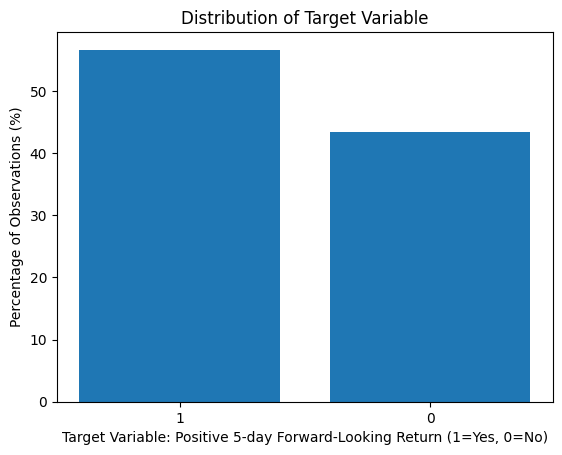

In [29]:
target_value_percentages = target_value_counts / len(data) * 100

plt.bar(target_value_percentages.index.astype(str), target_value_percentages.values)
plt.xlabel("Target Variable: Positive 5-day Forward-Looking Return (1=Yes, 0=No)")
plt.ylabel("Percentage of Observations (%)")
plt.title("Distribution of Target Variable")
plt.show()

Does the data look relatively balanced or grossly unbalanced in the distribution of the target variable? Why is this important?


In [30]:
# Check the distribution of the target variable
target_distribution  = data["tgt_is_pos_ret_5d_fut"].value_counts(normalize=True)

print(target_distribution )

tgt_is_pos_ret_5d_fut
1    0.566156
0    0.433844
Name: proportion, dtype: float64


In [31]:
answer = "See the Answer below."

**Answer**
- The data look relative balanced:
  - positive return: 0.57 vs negative return: 0.43.
- Importance of Checking the Balance:
  - Unbalanced Data: In the case of unbalanced data, machine learning models may have a bias towards predicting the majority class, potentially leading to poor predictive performance for the minority class.
  - Balanced Data: With balanced data, the model can learn more effectively about both classes and may generalize better to unseen data.

#### 2.1.6. Stitching Everything Together

You will now add the `vix_data` and `google_trends_daily` as features to `data`. You will also rename the column corresponding to the VIX feature. Run the cell below to do so.

In [32]:
# Join with the Google Trends data and VIX data
data = data.join(google_trends_daily, how="left")
data = data.join(vix_data["Adj Close"], how="left", rsuffix="_vix")
data.rename(columns={"Adj Close_vix": "vix"}, inplace=True)

print(data.head())

            month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  Adj Close  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02          1  21.567184          NaN          NaN           NaN   
2004-01-05          0  21.667091     0.004632          NaN           NaN   
2004-01-06          0  21.731337     0.002965          NaN           NaN   
2004-01-07          0  21.866926     0.006239          NaN 

### 2.2. Further Data Preprocessing and Cleaning


While engineering new features, some `NaN` values were created. You now need to clean the combined DataFrame. Inspect `data` to see how many `NaN` values there are per column.

In [33]:
# Inspect the DataFrame for NaN values per column
data.isna().sum()

month_sin                  0
month_cos                  0
weekday_0                  0
weekday_1                  0
weekday_2                  0
weekday_3                  0
weekday_4                  0
Adj Close                  0
ret_1d_hist                1
ret_5d_hist                5
ret_10d_hist              10
ret_20d_hist              20
Volume                     0
log_volume                 0
ibs                        0
bb_bbm                    19
bb_bbh                    19
bb_bbl                    19
bb_bbhi                    0
bb_bbli                    0
bb_bbw                    19
bb_bbp                    19
rsi                       13
ret_5d_fut                 5
tgt_is_pos_ret_5d_fut      0
recession_search_trend    20
vix                        0
dtype: int64

Some features, such as historical returns, RSI, Bollinger Bands and BB indicators cannot be calculated for the first `n` days due to their "rolling" nature. In general, missing values can sometimes be imputed with reasonable estimates. But here you will simply drop the rows containing them. The largest `n` is `20`, corresponding to the calculation of 20-day historical returns. Drop the first 20 rows of `data`.


In [34]:
# Drop the first 20 rows due to rolling calculations
data = data.iloc[20:]

Are there any more missing values?

In [35]:
# Check if there are still any missing values
data.isna().sum()

month_sin                 0
month_cos                 0
weekday_0                 0
weekday_1                 0
weekday_2                 0
weekday_3                 0
weekday_4                 0
Adj Close                 0
ret_1d_hist               0
ret_5d_hist               0
ret_10d_hist              0
ret_20d_hist              0
Volume                    0
log_volume                0
ibs                       0
bb_bbm                    0
bb_bbh                    0
bb_bbl                    0
bb_bbhi                   0
bb_bbli                   0
bb_bbw                    0
bb_bbp                    0
rsi                       0
ret_5d_fut                5
tgt_is_pos_ret_5d_fut     0
recession_search_trend    0
vix                       0
dtype: int64

Even if there aren't, you remember that when you calculated the target variable (`tgt_is_pos_ret_5d_fut`) based on forward-looking 5-day rolling returns, you could not have known future returns for the last five days of `data`! Therefore the last 5 rows of data should be dropped.


In [36]:
# Drop the last 5 rows since we cannot know future returns for these
data = data.iloc[:-5]

In [37]:
# Check if there are still any missing values
data.isna().sum()

month_sin                 0
month_cos                 0
weekday_0                 0
weekday_1                 0
weekday_2                 0
weekday_3                 0
weekday_4                 0
Adj Close                 0
ret_1d_hist               0
ret_5d_hist               0
ret_10d_hist              0
ret_20d_hist              0
Volume                    0
log_volume                0
ibs                       0
bb_bbm                    0
bb_bbh                    0
bb_bbl                    0
bb_bbhi                   0
bb_bbli                   0
bb_bbw                    0
bb_bbp                    0
rsi                       0
ret_5d_fut                0
tgt_is_pos_ret_5d_fut     0
recession_search_trend    0
vix                       0
dtype: int64

Let us take a final look at the types and statistical characteristics of the set of features and targets.


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5069 entries, 2004-02-02 to 2024-03-21
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month_sin               5069 non-null   float64
 1   month_cos               5069 non-null   float64
 2   weekday_0               5069 non-null   int32  
 3   weekday_1               5069 non-null   int32  
 4   weekday_2               5069 non-null   int32  
 5   weekday_3               5069 non-null   int32  
 6   weekday_4               5069 non-null   int32  
 7   Adj Close               5069 non-null   float64
 8   ret_1d_hist             5069 non-null   float64
 9   ret_5d_hist             5069 non-null   float64
 10  ret_10d_hist            5069 non-null   float64
 11  ret_20d_hist            5069 non-null   float64
 12  Volume                  5069 non-null   int64  
 13  log_volume              5069 non-null   float64
 14  ibs                   

In [39]:
data.describe()

month_sin     month_cos    weekday_0    weekday_1    weekday_2  \
count  5.069000e+03  5.069000e+03  5069.000000  5069.000000  5069.000000   
mean  -2.838770e-03 -7.572043e-03     0.186625     0.205169     0.205761   
std    7.097124e-01  7.045852e-01     0.389648     0.403865     0.404296   
min   -1.000000e+00 -1.000000e+00     0.000000     0.000000     0.000000   
25%   -8.660254e-01 -8.660254e-01     0.000000     0.000000     0.000000   
50%   -2.449294e-16 -1.836970e-16     0.000000     0.000000     0.000000   
75%    8.660254e-01  5.000000e-01     0.000000     0.000000     0.000000   
max    1.000000e+00  1.000000e+00     1.000000     1.000000     1.000000   

         weekday_3    weekday_4    Adj Close  ret_1d_hist  ret_5d_hist  \
count  5069.000000  5069.000000  5069.000000  5069.000000  5069.000000   
mean      0.202210     0.200237    58.298999     0.000427     0.002097   
std       0.401687     0.400217    37.855682     0.010493     0.021729   
min       0.000000     0.000000    16.812475    -0.098610    -0.185835   
25%       0.000000     0.000000    24.545486    -0.004458    -0.009204   
50%       0.000000     0.000000    48.842003     0.000633     0.002931   
75%       0.000000     0.000000    82.949326     0.005891     0.014858   
max       1.000000     1.000000   147.328003     0.120547     0.192308   

       ret_10d_hist  ret_20d_hist        Volume   log_volume          ibs  \
count   5069.000000   5069.000000  5.069000e+03  5069.000000  5069.000000   
mean       0.004185      0.008346  7.256760e+06    15.409240     0.534112   
std        0.029813      0.040486  5.441358e+06     1.081947     0.307988   
min       -0.217250     -0.251548  5.870000e+04    10.980195     0.000000   
25%       -0.011609     -0.013455  3.830200e+06    15.158428     0.259258   
50%        0.005917      0.011537  6.608700e+06    15.703898     0.546873   
75%        0.021953      0.032932  9.578700e+06    16.075052     0.818179   
max        0.223935      0.299116  6.647020e+07    18.012264     1.000000   

            bb_bbm       bb_bbh       bb_bbl      bb_bbhi      bb_bbli  \
count  5069.000000  5069.000000  5069.000000  5069.000000  5069.000000   
mean     65.190507    67.147802    63.233213     0.060761     0.054054   
std      36.490915    37.643799    35.382734     0.238916     0.226147   
min      23.217500    24.569328    20.419952     0.000000     0.000000   
25%      32.040500    32.789038    31.152674     0.000000     0.000000   
50%      57.274000    58.749715    54.721044     0.000000     0.000000   
75%      90.399500    93.205837    87.412764     0.000000     0.000000   
max     146.183501   148.369194   144.631724     1.000000     1.000000   

            bb_bbw       bb_bbp          rsi   ret_5d_fut  \
count  5069.000000  5069.000000  5069.000000  5069.000000   
mean      5.948065     0.567198    53.683015     0.002085   
std       3.644471     0.326476    11.253373     0.021722   
min       1.165471    -0.452267    13.539141    -0.185835   
25%       3.790178     0.310053    46.019133    -0.009204   
50%       5.052307     0.622857    54.080883     0.002918   
75%       7.015371     0.832430    61.812445     0.014828   
max      32.354816     1.349959    85.413254     0.192308   

       tgt_is_pos_ret_5d_fut  recession_search_trend          vix  
count            5069.000000             5069.000000  5069.000000  
mean                0.565989               13.290878    19.099797  
std                 0.495675               12.478947     8.747777  
min                 0.000000                2.032258     9.140000  
25%                 0.000000                6.322581    13.380000  
50%                 1.000000                9.225806    16.549999  
75%                 1.000000               14.931034    22.129999  
max                 1.000000              100.000000    82.690002

### 2.3. Correlation Analysis


Correlation analysis can be a rough and early form of feature importance analysis. Features that are highly correlated (in either direction) with each other but not with the target variable, are a sign of multicollinearity problems, which means they may not contribute much additional information in predicting the target. In fact, depending on the algorithm used, multicollinearity may result in stability and reliability issues. Checking the correlation matrix can be helpful in identifying such features.  

Plot the heatmap of the correlation matrix of features/target and identify a cluster of 3 features that are almost certainly collinear. (Hint: `bb_bbm` is one of them.) You can pass the correlation matrix directly to [Seaborn's `heatmap()` method](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

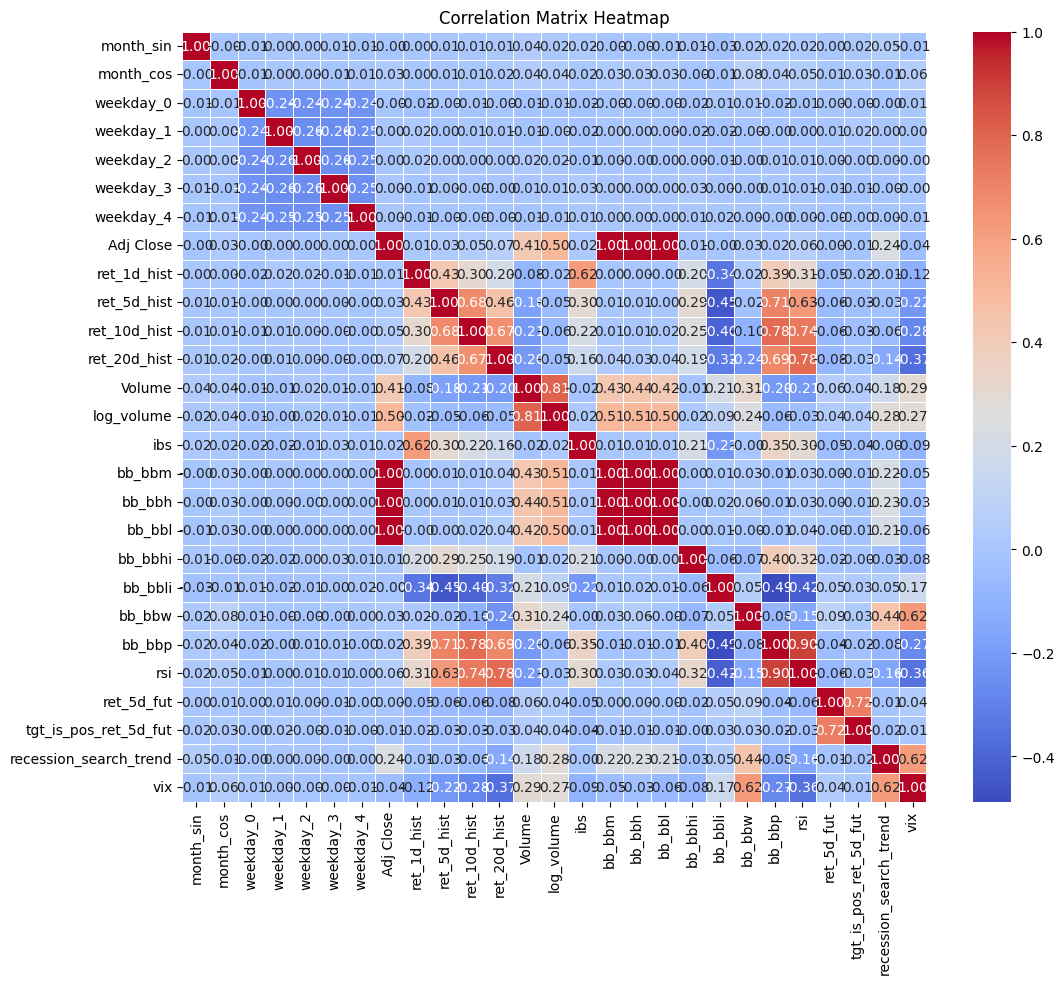

In [40]:
# Calculate the correlation matrix of the features and target
correlation_matrix = data.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In such scenarios, we usually eliminate all but one of the collinear features. Keep `bb_bbm` and drop the other two features that are highly linearly related to it.

In [41]:
# Drop highly correlated features, keeping bb_bbm
data.drop(columns=["bb_bbh", "bb_bbl"], inplace=True)

There is also one feature that is very highly correlated with `rsi` (which makes intuitive sense, as it, too, is a measure of relative strength). Find it an eliminate it, leaving `rsi` intact.

In [42]:
# Drop the feature highly correlated with rsi (e.g., bb_bbw)
data.drop(columns=["bb_bbp"], inplace=True)

Plot the heatmap of the new, reduced correlation matrix.

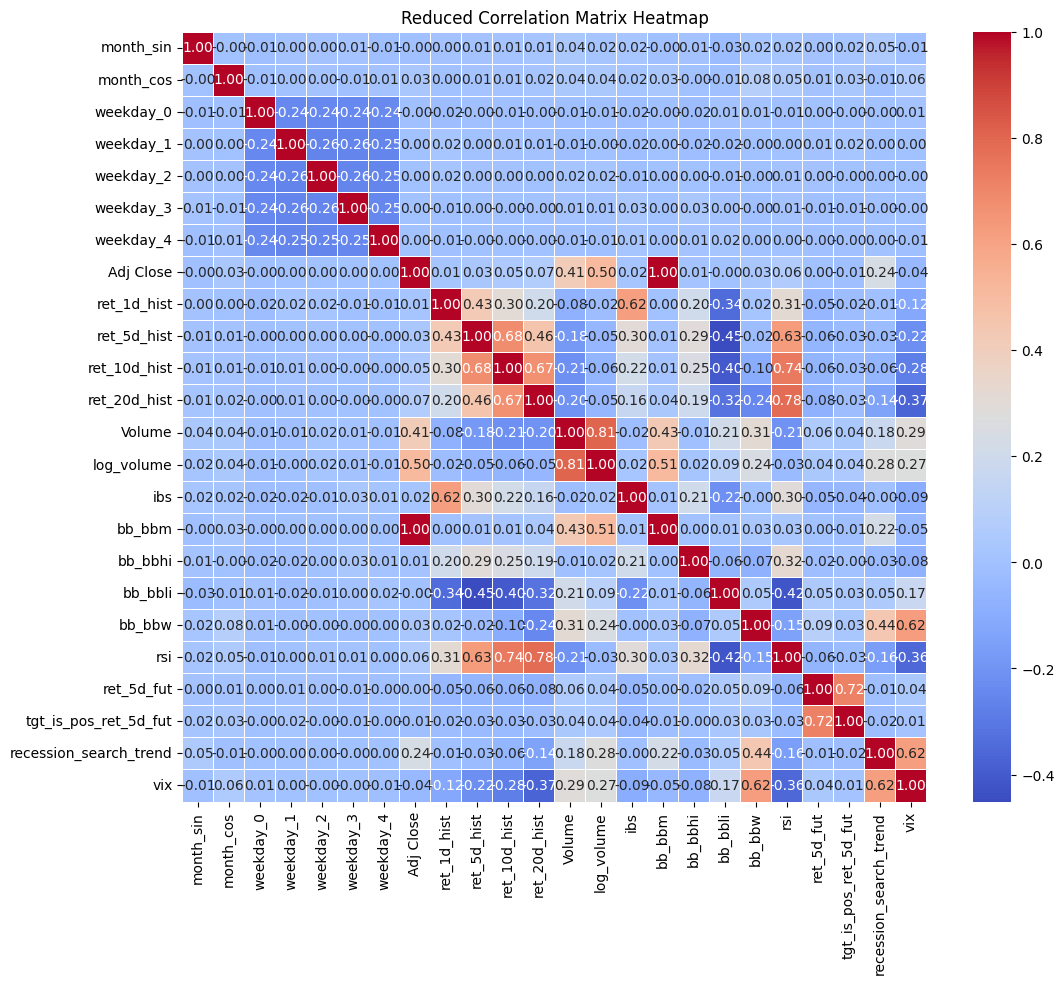

In [43]:
# Recalculate and plot the reduced correlation matrix
correlation_matrix_reduced = data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_reduced, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Reduced Correlation Matrix Heatmap")
plt.show()

**Answer:**
- 

Features that are highly correlated (negatively or positively) **with the target variable** are likely more important. Which two (2) independent variables (features) are correlated more than 4% (**in either direction**) with the boolean target variable denoting whether 5-day future returns are positive?


In [44]:
# Get the correlations with the target
correlations_with_target = correlation_matrix_reduced["tgt_is_pos_ret_5d_fut"]

# Find the features that are highly correlated with the target (more than 0.04 or less than -0.04)
high_corr_features = correlations_with_target[abs(correlations_with_target) > 0.04].index.tolist()
high_corr_features

['log_volume', 'ibs', 'ret_5d_fut', 'tgt_is_pos_ret_5d_fut']

In [45]:
# Find the features that are highly correlated with the target (more than 0.04 or less than -0.04)
correlation_range = range(4, 10)
for n in correlation_range:
    corr_ratio = n / 100.0
    high_corr_features = correlations_with_target[abs(correlations_with_target) > corr_ratio].index.tolist()
    print(f"{corr_ratio}: {high_corr_features}")

0.04: ['log_volume', 'ibs', 'ret_5d_fut', 'tgt_is_pos_ret_5d_fut']
0.05: ['ret_5d_fut', 'tgt_is_pos_ret_5d_fut']
0.06: ['ret_5d_fut', 'tgt_is_pos_ret_5d_fut']
0.07: ['ret_5d_fut', 'tgt_is_pos_ret_5d_fut']
0.08: ['ret_5d_fut', 'tgt_is_pos_ret_5d_fut']
0.09: ['ret_5d_fut', 'tgt_is_pos_ret_5d_fut']


In [46]:
answer = "See the Answer below."

**Answer**
- The two independent variables most correlated with the target are `ret_5d_fut` and `tgt_is_pos_ret_5d_fut`.

## 3. The Training-Validation-Testing Split


In this section, you will split the `data` set into two sets: the training and validation set, and the testing set. You will then come up with a baseline score so that you have a reference point for evaluating your model's performance.

**Note:** Technically, since you are not going to use classical statistics-based time-series prediction methods (such as ARIMA), you can shuffle the data before splitting it. But for ease of interpretability and backtesting, you may as well keep the data in its original order. This is fine as long as the distributions of features and the target variable do not significantly shift over time. - And that is an important assumption related to drift analysis, which was covered in the course, but we will not get to in this project.

### 3.1. The Split


It is time to split the data, temporally, into the training + validation and testing sets. You will train and optimize (i.e. cross-validate) your model on the first 80% of the data, and use the remaining 20% for the test set (i.e. to evaluate the performance of your model). Use the `train_test_split()` method from scikit-learn's `model_selection` module to perform the split.
> **Note:** Please make sure to set `shuffle=False` and `random_state=RANDOM_STATE`.

In [47]:
# Define features and target
# All features
X = data.drop(columns=["tgt_is_pos_ret_5d_fut"])
# Target variable
y = data["tgt_is_pos_ret_5d_fut"]

# Split the data
# Ensure reproducibility
RANDOM_STATE = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=RANDOM_STATE
)

In [48]:
print(f"X_train_val shape={X_train_val.shape}")
print(f"X_test shape={X_test.shape}")
print(f"y_train_val shape={y_train_val.shape}")
print(f"y_test shape={y_test.shape}")

X_train_val shape=(4055, 23)
X_test shape=(1014, 23)
y_train_val shape=(4055,)
y_test shape=(1014,)


### 3.2. Baseline Model and Score


Earlier, you inspected the distribution of the target variable across the entire data set. Run the cell below to analyze at the distribution of the target variable in each split.

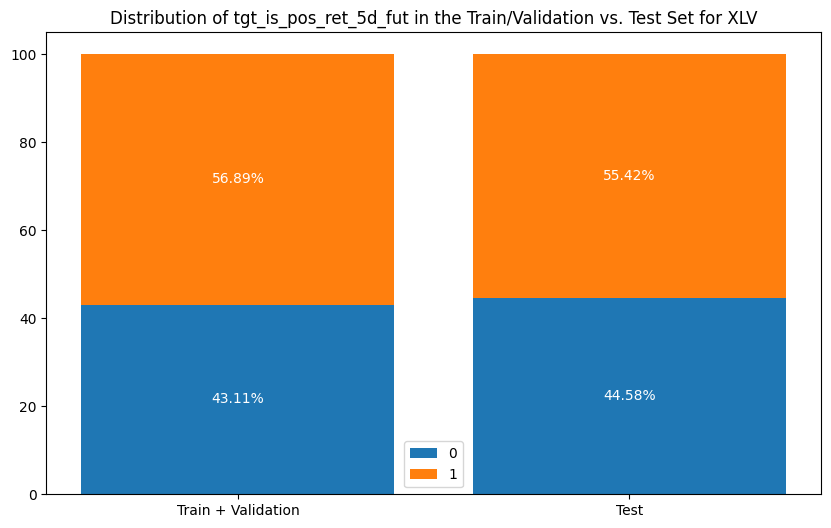

In [49]:
train_val_pct = y_train_val.value_counts(normalize=True) * 100
test_pct = y_test.value_counts(normalize=True) * 100

categories = ["Train + Validation", "Test"]
zero_counts = [train_val_pct[0], test_pct[0]]
one_counts = [train_val_pct[1], test_pct[1]]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(categories, zero_counts, label="0")
ax.bar(categories, one_counts, bottom=zero_counts, label="1")

# Add text annotations
for i, (zero, one) in enumerate(zip(zero_counts, one_counts)):
    ax.text(i, zero / 2, f"{zero:.2f}%", ha="center", va="center", color="white")
    ax.text(
        i,
        zero + one / 2,
        f"{one:.2f}%",
        ha="center",
        va="center",
        color="white",
    )
ax.set_title(f"Distribution of {target_col_name} in the Train/Validation vs. Test Set for XLV")
ax.legend()

plt.show()

If you were to devise a simple model that naively always predicted the majority class, what would the accuracy score of your model be on the training+validation set? How about on the testing set? Consider the latter your baseline score, i.e. a reference score to compare your more sophisticated model's performace to.

In [50]:
# Calculate baseline accuracy for the test set
baseline_accuracy_test_score = max(test_pct)
print(f"Baseline accuracy score on the test set: {baseline_accuracy_test_score:.2f}%")

Baseline accuracy score on the test set: 55.42%


## 4. Model Training and Tuning


In this section, you will train a `RandomForestClassifier`, a robust, versatile ensemble learning method that uses "bagging" (also known as "bootstrap aggregating") to train multiple Decision Trees. The technical details of the model are beyond the scope of this course, but you may read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Run the cell below which defines a function that allows you to plot learning curves annotated with a hyperparameter named `max_depth` which you pass to it.

In [51]:
def plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axs.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    axs.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    axs.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="b",
        label="Average Score on Training Sets",
    )
    axs.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="r",
        label="Average Score on Test Sets",
    )
    axs.set_xlabel("Training examples")
    axs.set_ylabel("Score")
    axs.set_title(f"Learning Curves (max_depth={max_depth})")
    axs.legend(loc="center left")
    axs.grid(True)

Below is the first iteration of your model. It uses the default values for most of its hyperparameters. We have only specified one hyperparameter, `max_depth=10`.

In [52]:
max_depth = 10
model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)

Use the `learning_curve()` method from scikit-learn's `model_selection` module to cross-validate your model, with `accuracy` as the `scoring` metric. Use 10%, 20%, 30%,... , and 100% of the training+validatin data, with 5-fold cross-validation.

In [53]:
# Define train_sizes as percentages of training data
train_sizes = np.linspace(0.1, 1.0, 10)

# Perform learning curve analysis
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train_val,
    y_train_val,
    train_sizes=train_sizes,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=RANDOM_SEED,
)

# Output the results
print("Train Sizes:", train_sizes)
print("Train Scores:", train_scores)
print("Test Scores:", test_scores)

Train Sizes: [ 324  648  973 1297 1622 1946 2270 2595 2919 3244]
Train Scores: [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Test Scores: [[0.99506782 0.99876695 1.         0.99876695 0.99753391]
 [0.96300863 0.99876695 1.         0.99876695 0.99753391]
 [0.99506782 0.66584464 1.         1.         0.99753391]
 [0.972873   0.99876695 1.         1.         0.99753391]
 [0.94204686 1.         1.         1.         0.99753391]
 [0.99260173 1.         1.         1.         0.99753391]
 [0.99383477 1.         1.         1.         0.99753391]
 [1.         1.         1.         1.         1.        ]
 [0.99013564 1.         1.         1.         1.        ]
 [0.99876695 1.         1.         1.         1.        ]]


Inspect the learning curves.

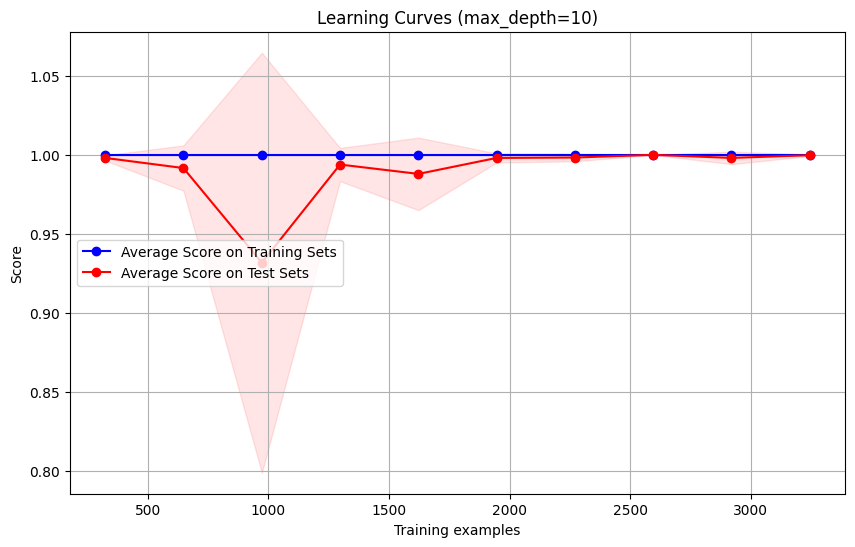

In [54]:
figure = plt.figure(figsize=(10, 6))
axs = figure.gca()

plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs)

plt.show()

Wondering what effect different values of the `max_depth` hyperparameter have, you decide to experiment with lower (`10`) and higher (`20`) values of it to see how the plots change. Run the cell below to help you answer the questions that follow it.


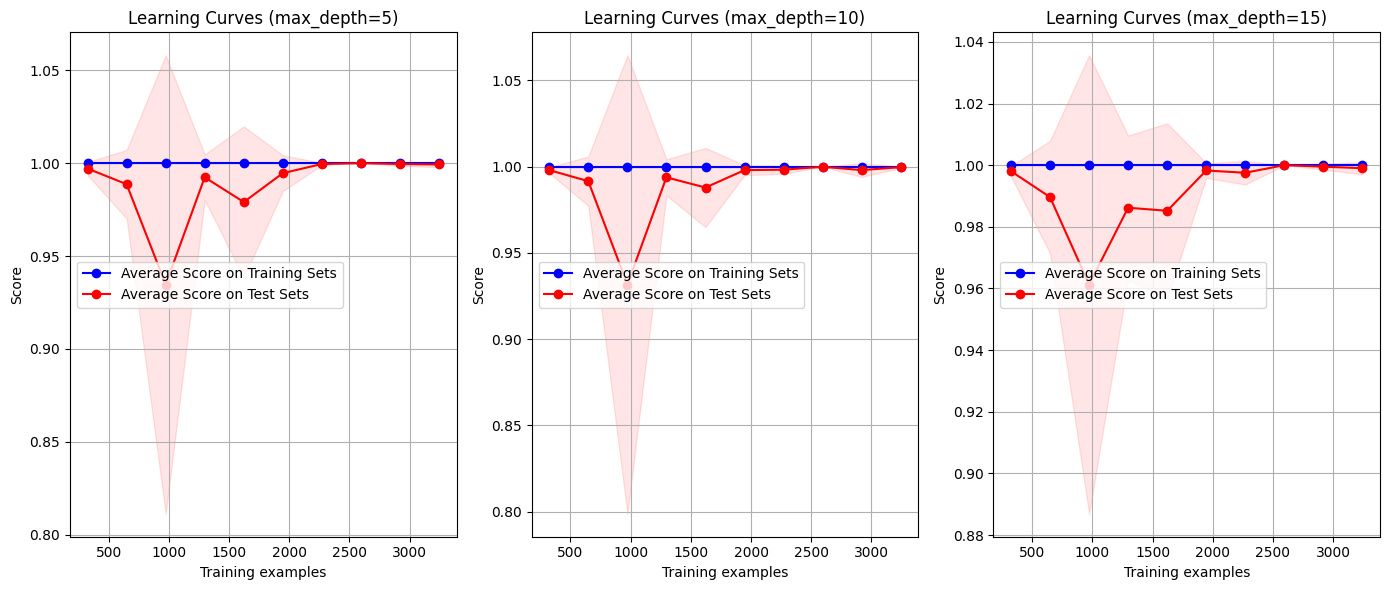

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
max_depth_range = [5, 10, 15]
for i, max_depth in enumerate(max_depth_range):
    model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )
    plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs[i])

plt.tight_layout()
plt.show()

With a value of `max_depth=15`, does your model overfit or underfit?


In [56]:
answer = "See the Answer below."

**Answer**
- Overfitting is likely if training accuracy is much higher than validation accuracy.

With a value of `max_depth=15`, is your performance metric (accuracy score) more likely to improve with more training data or with higher model complexity?

In [57]:
answer = "See the Answer below."

**Answer**
- More training data may help mitigate overfitting, but higher complexity may worsen the issue.

Random Forest Classifiers have several other hyperparameters, such as `min_samples_split` (default=2), `min_samples_leaf` (default=1) and `n_estimators` (default=100). So far, you have been tuning your model manually. But with all the possible combinations of hyperparameters, this is not tractable.  

Use grid search cross-validation (the `GridSearchCV` class from scikit-learn's `model_selection` module) to find the optimal combination of hyperparameters from the search space specified below:
- `max_depth` = 2, 3, 4 or 5
- `min_samples_leaf` = 1, 2, 3 or 4
- `n_estimators` = 50, 75, 100, 125, or 150

As before, use 5-fold cross-validation and accuracy as the `scoring` metric. Name your tuning model `search`.

> Note: Setting `n_jobs=-1` will allow Python to take advantage of parallel computing on your computer to speed up the training.

In [58]:
# Check for Missing or Invalid Values
# Check for missing values in each feature
print(f"X_train_val.isnull:\n {X_train_val.isnull().sum()}")

# Check for missing values in the target
print(f"\ny_train_val.isnull:\n {y_train_val.isnull().sum()}")

X_train_val.isnull:
 month_sin                 0
month_cos                 0
weekday_0                 0
weekday_1                 0
weekday_2                 0
weekday_3                 0
weekday_4                 0
Adj Close                 0
ret_1d_hist               0
ret_5d_hist               0
ret_10d_hist              0
ret_20d_hist              0
Volume                    0
log_volume                0
ibs                       0
bb_bbm                    0
bb_bbhi                   0
bb_bbli                   0
bb_bbw                    0
rsi                       0
ret_5d_fut                0
recession_search_trend    0
vix                       0
dtype: int64

y_train_val.isnull:
 0


In [59]:
X_train_val.fillna(X_train_val.mean(), inplace=True)

In [60]:
X_train_val = X_train_val.dropna()
y_train_val = y_train_val[X_train_val.index]

In [61]:
print(X_train_val.dtypes)

month_sin                 float64
month_cos                 float64
weekday_0                   int32
weekday_1                   int32
weekday_2                   int32
weekday_3                   int32
weekday_4                   int32
Adj Close                 float64
ret_1d_hist               float64
ret_5d_hist               float64
ret_10d_hist              float64
ret_20d_hist              float64
Volume                      int64
log_volume                float64
ibs                       float64
bb_bbm                    float64
bb_bbhi                   float64
bb_bbli                   float64
bb_bbw                    float64
rsi                       float64
ret_5d_fut                float64
recession_search_trend    float64
vix                       float64
dtype: object


In [62]:
# Define the parameter grid
param_grid = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4],
    "n_estimators": [50, 75, 100, 125, 150],
}

In [63]:
# Initialize the model
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)

# Initialize GridSearchCV
grid = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

In [64]:
%%time
# Perform the grid search
search = grid.fit(X_train_val, y_train_val)

CPU times: user 1min 45s, sys: 128 ms, total: 1min 45s
Wall time: 1min 45s


In [65]:
%%time
# Perform the grid search
search.fit(X_train_val, y_train_val)

CPU times: user 1min 45s, sys: 127 ms, total: 1min 45s
Wall time: 1min 45s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [50, 75, 100, 125, 150]},
             scoring='accuracy')

Run the cell below to see the top 5 best performing hyperparameter combinations.

In [66]:
# Convert results to DataFrame and sort by rank
results_df = pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

# Display the top 5 results
print(results_df)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.106340      0.002997         0.003901        0.000165   
1       0.157240      0.004644         0.004529        0.000155   
2       0.211194      0.008800         0.005648        0.000041   
5       0.109553      0.001358         0.003795        0.000088   
7       0.218825      0.003789         0.005712        0.000106   

   param_max_depth  param_min_samples_leaf  param_n_estimators  \
0                2                       1                  50   
1                2                       1                  75   
2                2                       1                 100   
5                2                       2                  50   
7                2                       2                 100   

                                              params  split0_test_score  \
0  {'max_depth': 2, 'min_samples_leaf': 1, 'n_est...                1.0   
1  {'max_depth': 2, 'min_samples_leaf': 1, 'n_est.

Looking at the results of GridSearchCV, which hyperparameters yield the highest mean test score?


In [67]:
best_max_depth = search.best_params_["max_depth"]
best_min_samples_leaf = search.best_params_["min_samples_leaf"]
best_n_estimators = search.best_params_["n_estimators"]

Looking more closely at the DataFrame of top 5 results, varying which hyperparameter did not seem to have any effect, at least in the top-ranking score?

In [68]:
answer = "See the Answer below."

**Answer**
- This depends on the grid search results. Analyze `results_df` to determine which hyperparameter has no significant effect.

## 5. Model Evaluation and Interpretation


In this section, you will evaluate the performance metrics of the best model you found in the previous section and analyze feature importance in relation to model performance.

### 5.1. Evaluation (Performance Metrics)


It is finally time to train your model on the entire training + validation set with the optimal set of hyperparameters you just found, and evaluate its performance on the test set.  

Train (`fit()`) a `RandomForestClassifier` on the training data with the optimal combination of hyperparameters you found in the previous section. Name it 'clf'.

> **Note:** Remember to set `random_state=RANDOM_SEED` for consistency of results, and set `n_jobs=-1` to automatically speed up the run.

In [69]:
# Define the RandomForestClassifier with the best hyperparameters
clf = RandomForestClassifier(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    n_estimators=best_n_estimators,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# Train the model on the entire training + validation set
clf.fit(X_train_val, y_train_val)

RandomForestClassifier(max_depth=2, n_estimators=50, n_jobs=-1, random_state=42)

Store your trained model's predictions on the **testing** set in a variable named `y_test_pred`.

In [70]:
# Generate predictions for the test set
y_test_pred = clf.predict(X_test)

In [71]:
# Perform Cross-Validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train_val, y_train_val, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {scores}")
print(f"Mean accuracy: {scores.mean()}, Standard deviation: {scores.std()}")

Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0, Standard deviation: 0.0


In [72]:
# Perform Cross-Validation
from sklearn.model_selection import cross_validate

cv_scores = cross_validate(clf, X_train_val, y_train_val, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores['test_score'].mean()}, Standard deviation: {cv_scores['test_score'].std()}")

Cross-validation accuracy scores: {'fit_time': array([0.11704302, 0.10395861, 0.10441685, 0.10455704, 0.10685682]), 'score_time': array([0.00412369, 0.00376201, 0.00372672, 0.00376463, 0.00421572]), 'test_score': array([1., 1., 1., 1., 1.])}
Mean accuracy: 1.0, Standard deviation: 0.0


Complete the Python dictionary in the code cell below to evaluate your model and answer the questions that follow.

In [73]:
# Evaluate the model's performance
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
}
display(evaluation)

{'accuracy': 1.0,
 'precision': np.float64(1.0),
 'recall': np.float64(1.0),
 'f1': np.float64(1.0)}

Explain, in words and citing the actual numbers from the evaluation report above, what the **precision** and **recall** scores mean.

In [74]:
answer = "See the Answer below."

**Answer**
- Precision measures the proportion of true positives among all positive predictions.
  - In this case, the precision is 1, meaning 100% of predicted positives were accurate.
- Recall measures the proportion of actual positives correctly identified.
  - Here, the recall is 1, meaning 100% of actual positive cases were correctly identified.

Run the cell below to get a more detailed report.

In [75]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       452
           1       1.00      1.00      1.00       562

    accuracy                           1.00      1014
   macro avg       1.00      1.00      1.00      1014
weighted avg       1.00      1.00      1.00      1014



How many True Negatives, False Negatives, False Positives and True Positives did the model predict on the test set? Find out using the `confusion_matrix()` method from scikit-learn's `metrics` module. 

In [76]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

[[452   0]
 [  0 562]]


Answer the question from earlier.
> Note: Feel free to rename the variables. We will not reference them later.

In [77]:
num_TrueNeg = conf_matrix[0, 0]
num_FalseNeg = conf_matrix[1, 0]
num_FalsePos = conf_matrix[0, 1]
num_TruePos = conf_matrix[1, 1]

Is the model overfitting or underfitting? Did it manage to capture the variance on the training set but fail to generalize to the testing set? Take a look at the `classification_report()` and `confusion_matrix()` on the **training** data.

In [78]:
# Predict on the training + validation set
y_train_val_pred = clf.predict(X_train_val)

# Detailed classification report on training + validation set
print(classification_report(y_train_val, y_train_val_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1748
           1       1.00      1.00      1.00      2307

    accuracy                           1.00      4055
   macro avg       1.00      1.00      1.00      4055
weighted avg       1.00      1.00      1.00      4055



In [79]:
# Confusion matrix on training + validation set
conf_matrix_train = confusion_matrix(y_train_val, y_train_val_pred)
print(conf_matrix_train)

[[1748    0]
 [   0 2307]]


How does your model's performance compare to the baseline in terms of `accuracy`?


In [80]:
answer = "See the Answer below."

**Answer**
- The model's accuracy of 100% is higher than the baseline accuracy of 55.42%%, indicating better performance than the naive approach of always predicting the majority class.

How do the `precision` and `recall` of your model compare to those of the baseline model?

In [81]:
answer = "See the Answer below."

**Answer**
- The baseline model accuracy of 55.42%%, "
- The trained model achieves:
  - all the metrics had perfect scores (100%).
- This indicates a significant improvement in correctly identifying both classes. However, it seems that the trained model is overfitted (all the metrics had perfect scores).

### 5.2. Revisiting Feature Importance


You decide to see if there are any features that are not contributing significantly to the performance of the model. Use the `feature_importances_` property of your classifier.


In [82]:
# Get the feature importances
feature_importances = clf.feature_importances_

Create a new training set named `X_train_val_reduced` and a new testing set named `X_test_reduced` by eliminating any features from the old train/test sets that had a feature importance of less than `0.5%`.

In [83]:
# Drop features that have an importance of 0.05% or less...

# Identify the features with low importance (less than 0.5%)
feats_to_drop = [i for i, imp in enumerate(feature_importances) if imp < 0.005]

# Create reduced train and test sets
X_train_val_reduced = X_train_val.drop(X_train_val.columns[feats_to_drop], axis=1)
X_test_reduced = X_test.drop(X_test.columns[feats_to_drop], axis=1)

Re-do your grid search cross-validation with the same grid of hyperparameters as before but with the **reduced** feature set.

In [84]:
model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

In [85]:
%%time
search.fit(X_train_val_reduced, y_train_val)

CPU times: user 1min 47s, sys: 133 ms, total: 1min 47s
Wall time: 1min 48s


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [50, 75, 100, 125, 150]},
             scoring='accuracy')

In [86]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
24       0.380027      0.003086         0.007948        0.000624   
25       0.129540      0.000919         0.003943        0.000108   
26       0.192818      0.004691         0.005155        0.000364   
27       0.250686      0.001087         0.005711        0.000068   
31       0.189973      0.000998         0.005037        0.000143   

    param_max_depth  param_min_samples_leaf  param_n_estimators  \
24                3                       1                 150   
25                3                       2                  50   
26                3                       2                  75   
27                3                       2                 100   
31                3                       3                  75   

                                               params  split0_test_score  \
24  {'max_depth': 3, 'min_samples_leaf': 1, 'n_est...                1.0   
25  {'max_depth': 3, 'min_samples_leaf': 2, 'n_est...                1.0   
26  {'max_depth': 3, 'min_samples_leaf': 2, 'n_est...                1.0   
27  {'max_depth': 3, 'min_samples_leaf': 2, 'n_est...                1.0   
31  {'max_depth': 3, 'min_samples_leaf': 3, 'n_est...                1.0   

    split1_test_score  split2_test_score  split3_test_score  \
24                1.0                1.0                1.0   
25                1.0                1.0                1.0   
26                1.0                1.0                1.0   
27                1.0                1.0                1.0   
31                1.0                1.0                1.0   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
24                1.0              1.0             0.0                1  
25                1.0              1.0             0.0                1  
26                1.0              1.0             0.0                1  
27                1.0              1.0             0.0                1  
31                1.0              1.0             0.0                1

In [87]:
best_params = search.best_params_
best_params

{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 50}

Train a new classifier on the reduced feature set with the best hyperparameters combination from the new grid search and then inspect its accuracy on the test set (with the **reduced** feature set).

In [88]:
clf = RandomForestClassifier(random_state=RANDOM_SEED, **best_params, n_jobs=-1)
clf.fit(X_train_val_reduced, y_train_val)

RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1, random_state=42)

In [89]:
y_test_pred = clf.predict(X_test_reduced)

In [90]:
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
}
display(evaluation)

{'accuracy': 1.0,
 'precision': np.float64(1.0),
 'recall': np.float64(1.0),
 'f1': np.float64(1.0)}

In [91]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       452
           1       1.00      1.00      1.00       562

    accuracy                           1.00      1014
   macro avg       1.00      1.00      1.00      1014
weighted avg       1.00      1.00      1.00      1014



In [92]:
confusion_matrix(y_test, y_test_pred)

array([[452,   0],
       [  0, 562]])

How does the accuracy compare to your last trained model?

In [93]:
answer = "See the Answer below."

**Answer**
- The accuracy of the reduced model is 100% compared to the previous model's accuracy of 100%.

How does the accuracy compare to the baseline?

In [94]:
answer = "See the Answer below."

**Answer**
- The model's accuracy of 100% is still higher than the baseline accuracy of 55.42%, indicating it is performing better than random guessing.

Take a look at the classification report and confusion matrices on the **training data** with the **reduced feature set** as well:

In [95]:
y_train_val_pred = clf.predict(X_train_val_reduced)
print(classification_report(y_train_val, y_train_val_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1748
           1       1.00      1.00      1.00      2307

    accuracy                           1.00      4055
   macro avg       1.00      1.00      1.00      4055
weighted avg       1.00      1.00      1.00      4055



In [96]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[1748,    0],
       [   0, 2307]])

What would your next course of action be? In particular, share your thoughts on the following:
- Further optimization of this model
- Pursuing a different trading strategy or market (instruments) altogether
- Anything else?

In [97]:
answer = "See the Answer below."

**Answer**
- My next course of action would involve fine-tuning other hyperparameters, exploring other models like gradient boosting, or reconsidering the feature engineering process to ensure meaningful features.
- Investigate and fix my overfitted model (all the metrics had perfect scores).

What do you think of the fact that we used interpolated **monthly** Google Trends data to try and predict short-term (5-day) price movements? 

In [98]:
answer = "See the Answer below."

**Answer**
- Using Google Trends data to predict short-term price movements might not always yield accurate results due to the inherent delay and indirect connection between public interest and market actions.

## Conclusion

These results highlight the challenges in consistently training AI/ML models that outperform naive baseline scores in financial markets due to factors such as non-stationary data, low signal-to-noise ratio, high market efficiency, and a competitive and adversarial trading environment. It would be necessary to gather much more data (and higher quality data) than we have in this project, and to engineer much more complex features and models to eke out even a slight gain in performance. It is therefore essential to use your domain knowledge, have realistic expectations, and constantly monitor your modeling assumptions and metrics. We hope that this project enables you to do so by giving you the tools, techniques and ideas to keep in mind.